# Sandbox environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
import environment
import utils 
from importlib import reload

# Critic analysis

**Idea:** to see if there is any error in the critic's code or if it works properly, we can use an optimal policy to gather trajectories and see if the critic learns from them the real value of the states under an optimal policy.

We have two ways in which the critic's target can be computed:
- Temporal Difference (TD) learning: $V(s) \approx \gamma V(s') + r(s,a)$
- Monte Carlo (MC) learning: $V(s) \approx \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'}$

The first one can be very biased by its nature, but in this simple taks should converge anyway.
The latter instead should be unbiased but more noisy.

## Optimal policy (hardcoded)
Use method get_optimal_action of the environment.

In [2]:
reload(environment)
reload(utils)

<module 'utils' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/utils.py'>

In [ ]:
%matplotlib notebook
utils.render(x=5, y=5, goal=[4,4])
%matplotlib inline

## TD Critic Agent

In [ ]:
from networks import Critic

In [ ]:
class CriticAgentTD():
    def __init__(self, observation_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.critic = Critic(observation_space, discrete=True, project_dim=project_dim)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
    def forward(self, state):
        state = torch.from_numpy(state)
        return self.critic(state)
    
    def update(self, rewards, states, done):
        rewards = torch.tensor(rewards) 
        old_states = torch.tensor(states[:-1]).view(1,-1)
        new_states = torch.tensor(states[1:]).view(1,-1)
        done = torch.LongTensor(done.astype(int))
        loss = self.update_critic(rewards, new_states, old_states, done)
        return loss
        
    def update_critic(self, rewards, new_states, old_states, done):
        # Predictions
        V_pred = self.critic(old_states).squeeze()
        # Targets
        V_trg = self.critic(new_states).squeeze()
        V_trg = (1-done)*self.gamma*V_trg + rewards
        # MSE loss
        loss = torch.sum((V_pred - V_trg)**2)
        # backprop and update
        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()
        return loss.item()

In [3]:
def play_optimal(env):
    state = env.reset(random_init = True)
    
    rewards = []
    done = []
    states = [state]
    
    while True:
        action = env.get_optimal_action()
        
        new_state, reward, terminal, info = env.step(action) 
        states.append(new_state)
        rewards.append(reward)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
    
    return np.array(rewards), np.array(states), np.array(done)

In [4]:
def train_critic_TD(n_episodes = 100, lr = 0.01, gamma = 0.99):
    
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    
    observation_space = 10*10
    critic = CriticAgentTD(observation_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, states, done = play_optimal(env)
        
        loss = critic.update(rewards, states, done)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return critic, losses

In [5]:
G = 0.99
critic_TD, losses_TD = train_critic_TD(1000, lr=1e-2, gamma=G)

NameError: name 'CriticAgentTD' is not defined

In [13]:
def plot_loss(losses, x='', y='', t='', xlog=False, ylog=False):
    episodes = np.arange(len(losses)) + 1
    plt.figure(figsize=(8,6))
    plt.plot(episodes, losses)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.title(t, fontsize=16)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

In [ ]:
x = "Number of episodes"
y = "Squared error of the prediction [log]"
t = "Critic trained through optimal policy and TD"
plot_loss(losses_TD, x, y, t, ylog=True)

In [ ]:
def get_real_value_map(env, gamma):
    distances = np.zeros((env.boundary[0], env.boundary[1] ))
    for x in range(env.boundary[0]):
        for y in range(env.boundary[1]):
            d = env.dist_to_goal([x,y])
            distances[x,y] = d
    distances = distances.flatten() -1
    real_values = gamma**distances
    real_values[-1] = 1
    return real_values.reshape(env.boundary[0], env.boundary[1])

In [ ]:
def value_map(critic, env, gamma):
    states = np.arange(env.boundary[0]*env.boundary[1]).reshape(1,-1)
    values = critic.forward(states).squeeze()
    values = values.detach().numpy().reshape(env.boundary[0], env.boundary[1])
    
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    values[-1,-1] = 1
    plt.imshow(values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map", fontsize=16)
    plt.colorbar()
    
    real_values = get_real_value_map(env, gamma)
    plt.subplot(122)
    plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Real values", fontsize=16)
    plt.colorbar()
    
    plt.figure(figsize=(7,6))
    diff = values-real_values
    diff[-1,-1] = 0
    plt.imshow(diff)
    #plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Difference from real value", fontsize=16)
    plt.colorbar()
    

In [ ]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
value_map(critic_TD, env, gamma = G)

### MC Critic Agent

In [ ]:
class CriticAgentMC():
    def __init__(self, observation_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.critic = Critic(observation_space, True, project_dim)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
    def forward(self, state):
        state = torch.from_numpy(state)
        return self.critic(state)
    
    def update(self, rewards, states, done):
        old_states = torch.tensor(states[:-1]).view(1,-1)
        new_states = torch.tensor(states[1:]).view(1,-1)
        
        loss = self.update_critic(rewards, old_states)
        return loss
        
    def update_critic(self, rewards, old_states):
        # Predictions
        V_pred = self.critic(old_states).squeeze()
        # Discount factors
        Gamma = np.array([self.gamma**i for i in range(rewards.shape[0])])
        # reverse everything to use cumsum in right order, then reverse again
        Gt = np.cumsum(rewards[::-1]*Gamma[::-1])[::-1]
        # Rescale so that present reward is never discounted
        discounted_rewards =  Gt/Gamma
        dr = torch.tensor(discounted_rewards).float()    #.to(self.device)
        # MSE loss
        loss = torch.sum((V_pred - dr)**2)
        # backprop and update
        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()
        return loss.item()

In [ ]:
def train_critic_MC(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    
    observation_space = 10*10
    critic = CriticAgentMC(observation_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, states, done = play_optimal(env)
        
        loss = critic.update(rewards, states, done)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return critic, losses

In [ ]:
critic_MC, losses_MC = train_critic_MC(1000, lr=1e-2)

In [ ]:
x = "Number of episodes"
y = "Critic loss"
t = "Critic with MC estimation and optimal policy"
plot_loss(losses_MC, x, y, t, ylog=True)

In [ ]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
value_map(critic_MC, env, gamma = 0.99)

## Confrontation TD-MC

In [ ]:
episodes = np.arange(len(losses_MC)) + 1
plt.figure(figsize=(8,6))
plt.plot(episodes, losses_MC, label='MC')
plt.plot(episodes, losses_TD, label='TD')
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Squared error of the prediction", fontsize=16)
plt.title("Critic trained through optimal policy", fontsize=16)
plt.yscale("log")
plt.legend(fontsize=13)
plt.show()

**Comment:** Using TD learning with the optimal actor feeding information is more efficient at the beginning, whereas in the long run MC learning is better.

In [ ]:
def TD_vs_MC(TD_critic, MC_critic, env):
    states = np.arange(env.boundary[0]*env.boundary[1]).reshape(1,-1)
    values_TD = TD_critic.forward(states).squeeze()
    values_TD = values_TD.detach().numpy().reshape(env.boundary[0], env.boundary[1])

    values_MC = MC_critic.forward(states).squeeze()
    values_MC = values_MC.detach().numpy().reshape(env.boundary[0], env.boundary[1])
    
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    values_TD[-1,-1] = 1
    plt.imshow(values_TD, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map TD", fontsize=16)
    plt.colorbar()

    plt.subplot(122)
    #plt.imshow(values-real_values)
    values_MC[-1,-1] = 1
    plt.imshow(values_MC, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map MC", fontsize=16)
    plt.colorbar()


In [ ]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
TD_vs_MC(critic_TD, critic_MC, env)

## Actor analysis

**Idea:** substitute a critic with an hardcoded version that knows the optimal value of each cell, that is $\gamma^{d-1}$, considering
- a reward of 0 for all the steps except the one that bring the agent to the goal;
- a discount factor of $\gamma$;
- a distance (measured in minimum number of moves from A to B) d.

This means that the cells that are 1 step away form the goal have a value of 1, those 2 steps away of $\gamma$, 3 steps $\gamma^2$ and so on.

## TD actor
Using Temporal Difference estimation of the advantage with the optimal critic.

In [ ]:
from torch.distributions import Categorical
from networks import Actor

In [ ]:
class ActorAgentTD():
    def __init__(self, observation_space, action_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.actor = Actor(observation_space, action_space, discrete=True, project_dim=project_dim)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=lr)
        
    def get_action(self, state, return_log=False, **kwargs):
        state = torch.from_numpy(state)
        log_probs = self.actor(state)
        dist = torch.exp(log_probs)
        probs = Categorical(dist)
        action =  probs.sample().item()
        if return_log:
            return action, log_probs.view(-1)[action]
        else:
            return action
    
    def critic(self, state, env):
        """Implements optimal critic given the sandbox environment."""
        #print("State.shape: ", state.shape)
        distances = []
        for s in state:
            s_decoded = [s//env.boundary[0], s%env.boundary[1]]
            #print("\n\tState %d decoded in (%d, %d)"%(s, s_decoded[0], s_decoded[1]))
            d = env.dist_to_goal(s_decoded)
            #print("\tGoal in (%d,%d)"%(env.goal[0], env.goal[1]))
            #print("\tDistance from goal: ", d)
            distances.append(d)
        distances = np.array(distances) -1
        values = torch.tensor(self.gamma**distances).float()
        #print("Distances: ", distances)
        #print("Values: ", values,'\n')
        return values
        
    
    def update(self, rewards, log_probs, states, done, env):
        rewards = torch.tensor(rewards) 
        old_states = states[:-1]
        new_states = states[1:]
        done = torch.LongTensor(done.astype(int))
        log_probs = torch.stack(log_probs)
        loss = self.update_actor(rewards, log_probs, new_states, old_states, done, env)
        return loss
        
    def update_actor(self, rewards, log_probs, new_states, old_states, done, env):
        # Get values from critic
        V_old = self.critic(old_states, env)
        V_new = self.critic(new_states, env)
        # Compute advantage as value(new_s) + reward - value(old_s)
        A = (1.-done)*V_new + rewards - V_old
        # Compute - gradient
        policy_gradient = - log_probs*A
        #print("policy_gradient ", policy_gradient.shape)
        # Use it as loss
        policy_grad = torch.sum(policy_gradient)
        # backprop and update
        self.actor_optim.zero_grad()
        policy_grad.backward()
        self.actor_optim.step()
        return policy_grad.item()


In [3]:
def play_episode_A2C(agent, env, return_states=False):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    done = []
    
    if return_states:
        states = [state]
        
        
    steps = 0
    while True:
        state = np.array([state])
        action, log_prob = agent.get_action(state, return_log = True)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        
        if return_states:
            states.append(new_state)
            
        rewards.append(reward)
        log_probs.append(log_prob)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
       
    rewards = np.array(rewards)
    done = np.array(done)
    
    if return_states:
        return rewards, log_probs, np.array(states), done
    else:
        return rewards, log_probs, done

In [ ]:
def train_actor_TD(n_episodes = 100, lr = 1e-2, gamma = 0.99):
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=100)
    observation_space = 10*10
    action_space = 4
    actor = ActorAgentTD(observation_space, action_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(actor, env, return_states=True)
        loss = actor.update(rewards, log_probs, states, done, env)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return actor, losses

In [ ]:
actor_TD, actor_loss_TD = train_actor_TD(1000)

In [ ]:
%matplotlib notebook
utils.render(actor_TD, x=10, y=10, goal=[9,9])
%matplotlib inline

## MC actor

In [ ]:
class ActorAgentMC():
    def __init__(self, observation_space, action_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.actor = Actor(observation_space, action_space, discrete=True, project_dim=project_dim)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=lr)
        
    def get_action(self, state, return_log=False, **kwargs):
        state = torch.from_numpy(state)
        log_probs = self.actor(state)
        dist = torch.exp(log_probs)
        probs = Categorical(dist)
        action =  probs.sample().item()
        if return_log:
            return action, log_probs.view(-1)[action]
        else:
            return action
    
    def critic(self, state, env):
        """Implements optimal critic given the sandbox environment."""
        #print("State.shape: ", state.shape)
        distances = []
        for s in state:
            s_decoded = [s//env.boundary[0], s%env.boundary[1]]
            #print("\n\tState %d decoded in (%d, %d)"%(s, s_decoded[0], s_decoded[1]))
            d = env.dist_to_goal(s_decoded)
            #print("\tGoal in (%d,%d)"%(env.goal[0], env.goal[1]))
            #print("\tDistance from goal: ", d)
            distances.append(d)
        distances = np.array(distances) -1
        values = torch.tensor(self.gamma**distances).float()
        #print("Distances: ", distances)
        #print("Values: ", values,'\n')
        return values
        
    
    def update(self, rewards, log_probs, states, done, env):
        Gamma = np.array([self.gamma**i for i in range(rewards.shape[0])])
        # reverse everything to use cumsum in right order, then reverse again
        Gt = np.cumsum(rewards[::-1]*Gamma[::-1])[::-1]
        # Rescale so that present reward is never discounted
        discounted_rewards =  Gt/Gamma
        
        # Wrap variables in tensors
        dr = torch.tensor(discounted_rewards).float()  
        old_states = states[:-1]
        new_states = states[1:]
        done = torch.LongTensor(done.astype(int))
        log_probs = torch.stack(log_probs)
        loss = self.update_actor(dr, log_probs, old_states, env)
        return loss
        
    def update_actor(self, dr, log_probs, old_states, env):
        # Get values from critic
        V_old = self.critic(old_states, env)
        # Compute advantage as total return - value(s)
        A = dr - V_old
        # Compute - gradient
        policy_gradient = - log_probs*A
        # Use it as loss
        policy_grad = torch.sum(policy_gradient)
        # backprop and update
        self.actor_optim.zero_grad()
        policy_grad.backward()
        self.actor_optim.step()
        return policy_grad.item()


In [ ]:
def train_actor_MC(n_episodes = 100, lr = 1e-2, gamma = 0.99):
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=100)
    observation_space = 10*10
    action_space = 4
    actor = ActorAgentMC(observation_space, action_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(actor, env, return_states=True)
        loss = actor.update(rewards, log_probs, states, done, env)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return actor, losses

In [ ]:
actor_MC, actor_loss_MC = train_actor_MC(1000)

In [ ]:
%matplotlib notebook
utils.render(actor_MC, x=10, y=10, goal=[9,9])
%matplotlib inline

**Comment:** both actors learn correctly the optimal policy if the advantages we provide for the update are computed by an optimal critic. Also we've seen that both the critics learn correctly if feeded trajectories made by an optimal actor. The last thing that we need to be sure of is that no numerical instability arises by coupling the two learning processes.

## Actor-Critic with MC estimation

In [4]:
import ActorCritic
reload(ActorCritic)

<module 'ActorCritic' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/ActorCritic.py'>

In [5]:
def train_sandbox_A2C(n_episodes = 100, lr = 1e-2, gamma = 0.99, TD=False, twin=True, tau=0.005):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=100)
    observation_space = 10*10
    action_space = 4
    # Init agent
    agent = ActorCritic.A2C(observation_space, action_space, lr, gamma, TD=TD, discrete=True, project_dim=16,
                            twin=twin, tau=tau)
    performance = []
    critic_losses = []
    actor_losses = []
    
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(agent, env, return_states=True)
        critic_loss, actor_loss = agent.update(rewards, log_probs, states, done)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.2f"%(e+1, np.mean(performance[-10:])))

    return agent, np.array(performance), np.array(critic_losses), np.array(actor_losses)

In [6]:
MC_A2C, MC_reward, MC_critic_loss, MC_actor_loss = train_sandbox_A2C(500, TD=False)


Agent architecture: 
 Sequential(
  (0): Embedding(100, 16)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=4, bias=True)
  (6): LogSoftmax()
)

Critic architecture: 
 Sequential(
  (0): Embedding(100, 16)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
)

Critic architecture: 
 Sequential(
  (0): Embedding(100, 16)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
)
Episode 10 - reward: -8.20
Episode 20 - reward: -7.00
Episode 30 - reward: -7.40
Episode 40 - reward: -7.60
Episode 50 - reward: -4.10
Episode 60 - reward: -4.60
Episode 70 - reward: -0.

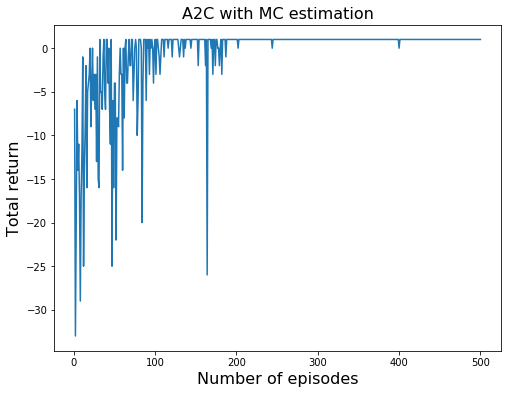

In [14]:
x = "Number of episodes"
y = "Total return"
t = "A2C with MC estimation"
plot_loss(MC_reward, x, y, t)

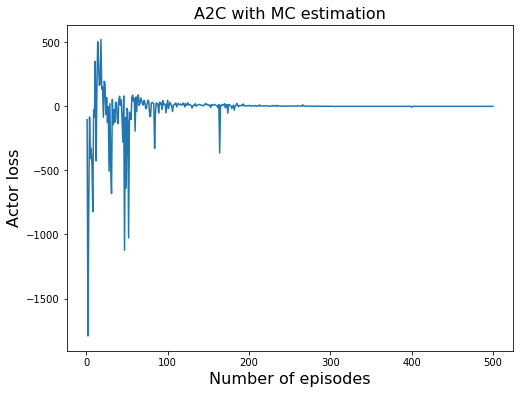

In [15]:
x = "Number of episodes"
y = "Actor loss"
t = "A2C with MC estimation"
plot_loss(MC_actor_loss, x, y, t)

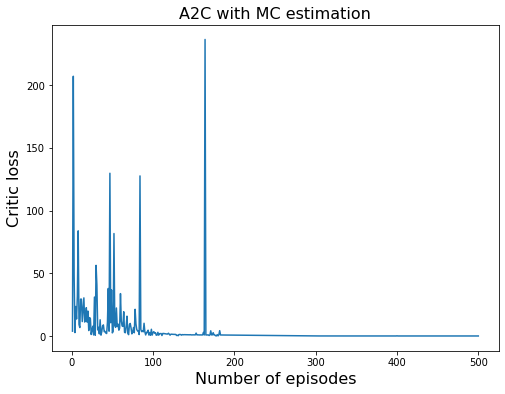

In [16]:
x = "Number of episodes"
y = "Critic loss"
t = "A2C with MC estimation"
plot_loss(MC_critic_loss, x, y, t)

<IPython.core.display.Javascript object>


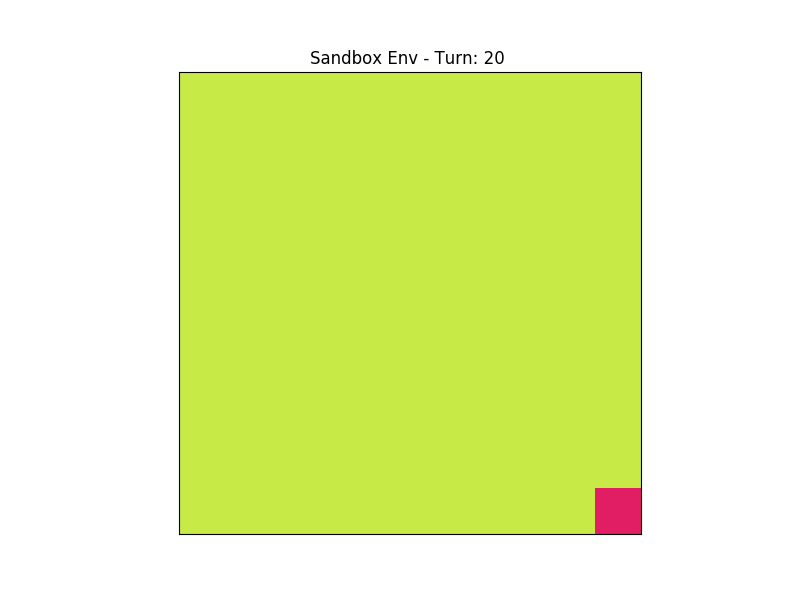

In [17]:
%matplotlib notebook
utils.render(MC_A2C, x=10, y=10, goal=[9,9])
%matplotlib inline

## Actor-Critic with TD estimation

In [7]:
import ActorCritic
reload(ActorCritic)

<module 'ActorCritic' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/ActorCritic.py'>

In [9]:
TD_A2C, TD_reward, TD_critic_loss, TD_actor_loss = train_sandbox_A2C(500, TD=True, twin=True, tau=0.5)


Agent architecture: 
 Sequential(
  (0): Embedding(100, 16)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=4, bias=True)
  (6): LogSoftmax()
)

Critic architecture: 
 Sequential(
  (0): Embedding(100, 16)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
)

Critic architecture: 
 Sequential(
  (0): Embedding(100, 16)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
)

Critic architecture: 
 Sequential(
  (0): Embedding(100, 16)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=

KeyboardInterrupt: 

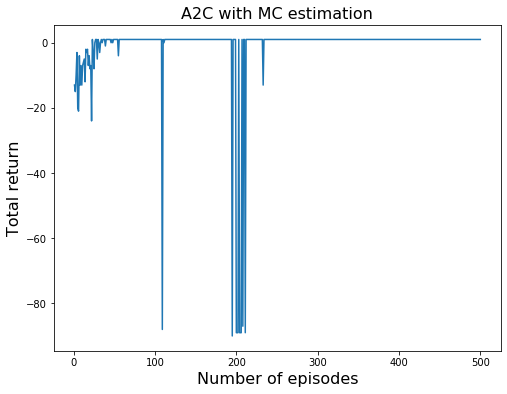

In [22]:
x = "Number of episodes"
y = "Total return"
t = "A2C with MC estimation"
plot_loss(TD_reward, x, y, t)

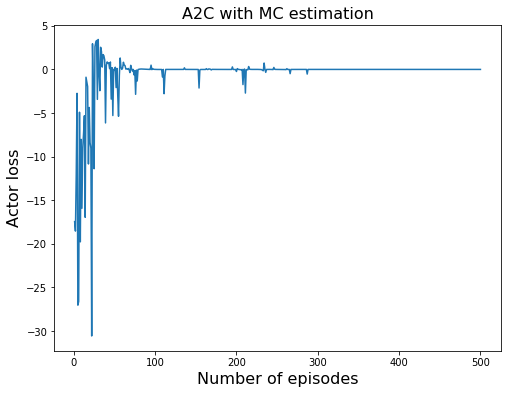

In [23]:
x = "Number of episodes"
y = "Actor loss"
t = "A2C with MC estimation"
plot_loss(TD_actor_loss, x, y, t)

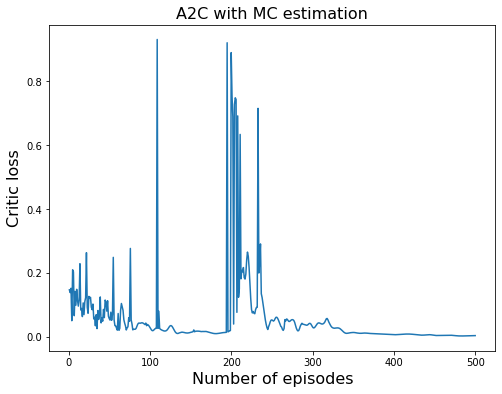

In [24]:
x = "Number of episodes"
y = "Critic loss"
t = "A2C with MC estimation"
plot_loss(TD_critic_loss, x, y, t)

<IPython.core.display.Javascript object>


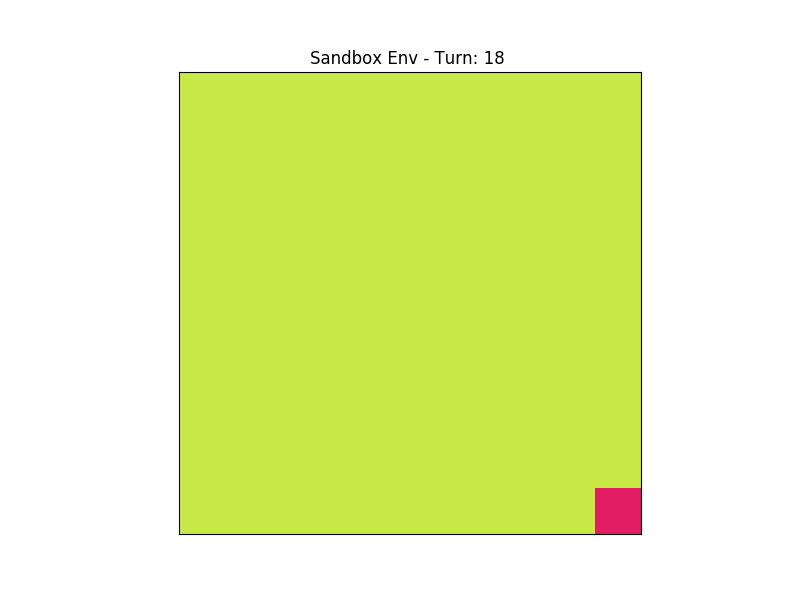

In [25]:
%matplotlib notebook
utils.render(TD_A2C, x=10, y=10, goal=[9,9])
%matplotlib inline

**Comment:** Both agent can learn the optimal policy IF during the initial phase are able to encounter the goal. Being the reward not much informative, they always learn to avoid hitting the borders of the map, but TD agent seems to learn the optimal policy only when the map is small enough to find it randomly. To be sure of the successfull learning one should find some ways to introduce exploration in this Actor-Critic setup, that as it is is devoted only to exploitation.